---

**<h1><center>Análisis de la calidad de trozos de caña de azúcar mediante visión artificial</center></h1>**

**<h2><center> Visión Artificial - 2024-2</center></h2>**

<center><img src="unal.png" width="300"></center>

**<h3> Presentado por: </h3>**
<ul>
  <li>Juan Esteban Arango Zapata - <a href="mailto:juarangoz@unal.edu.co">juarangoz@unal.edu.co</a> - CC 1018230863</li>
  <li>Paulina Hernández Morales - <a href="mailto:pauhernandezmo@unal.edu.co">pauhernandezmo@unal.edu.co</a> - TI 1035420888</li>
  <li>Jimena Hernández Castillo - <a href="mailto:jihernandezc@unal.edu.co">jihernandezc@unal.edu.co</a> - TI 1022094340</li>
  <li>Juan Camilo López López - <a href="mailto:julopezlop@unal.edu.co">julopezlop@unal.edu.co</a> - CC 1025533050</li>
</ul>

---

**<h3><center> Objetivo del proyecto </h3></center>**
<p>Desarrollar un modelo de visión artificial que permita clasificar trozos de caña de azúcar en tres categorías: sanos, dañados y mutilados, utilizando un conjunto de imágenes y técnicas de procesamiento de imágenes.</p>

**<h3><center> Descripción del Dataset </h3></center>**

**<h4>Contenido del Dataset:</h4>**  

<p>El dataset utilizado en el proyecto, fue proporcionado por la empresa <b>Tecde</b> y está conformado por <b>58 imágenes</b> de trozos de caña de azúcar, las cuales se encuentran clasificadas en tres categorías: sanos (21 imágenes), dañados (19 imágenes) y mutilados (18 imágenes). Cada imagen tiene un tamaño de <b>3072x4096 px.</b></p>

**<h4>Limitaciones:</h4>**

<ul>
    <li>El dataset es pequeño, lo que puede afectar la capacidad de generalización del modelo.</li>
    <li>No se encontraron datasets públicos que contengan imágenes de trozos de caña de azúcar, lo que limita la posibilidad de comparar los resultados obtenidos con otros modelos.</li>

**<h3><center>Metodología</center></h3>**

**<h4>Importar de librerias:</h4>**

In [1]:
!python -m pip install -U pip
!python -m pip install -U scikit-image opencv-python-headless

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from sklearn.cluster import KMeans
from scipy import ndimage
import copy
import shutil
from skimage.morphology import remove_small_holes, remove_small_objects


**<h4>Cargar y visualizar las imágenes originales:</h4>**

Dado el gran tamaño de las imágenes, se procede a cargar y visualizar una muestra de las imágenes originales, a la cual se le aplicará un preprocesamiento para reducir su tamaño y aumentar la eficiencia al procesar las imágenes.

In [2]:
#Cargar imagenes
healthy = [cv2.cvtColor(cv2.imread(f'data/healthy/healthy{i}.jpg'), cv2.COLOR_BGR2RGB) for i in range(1, 22)]
damaged = [cv2.cvtColor(cv2.imread(f'data/damaged/damaged{i}.jpg'), cv2.COLOR_BGR2RGB) for i in range(1, 20)]
mutilated = [cv2.cvtColor(cv2.imread(f'data/mutilated/mutilated{i}.jpg'), cv2.COLOR_BGR2RGB) for i in range(1, 18)]

In [3]:
def reducir_imagen(imagen, escala=0.5):
    """
    Reduce el tamaño de la imagen usando interpolación por área.
    """
    nuevo_tamano = (int(imagen.shape[1] * escala), int(imagen.shape[0] * escala))
    return cv2.resize(imagen, nuevo_tamano, interpolation=cv2.INTER_AREA)

# Aplicar reducción a muestras aleatorias de cada categoría
healthy_sample = [reducir_imagen(img, 0.5) for img in random.sample(healthy, 3)]
damaged_sample = [reducir_imagen(img, 0.5) for img in random.sample(damaged, 3)]
mutilated_sample = [reducir_imagen(img, 0.5) for img in random.sample(mutilated, 3)]

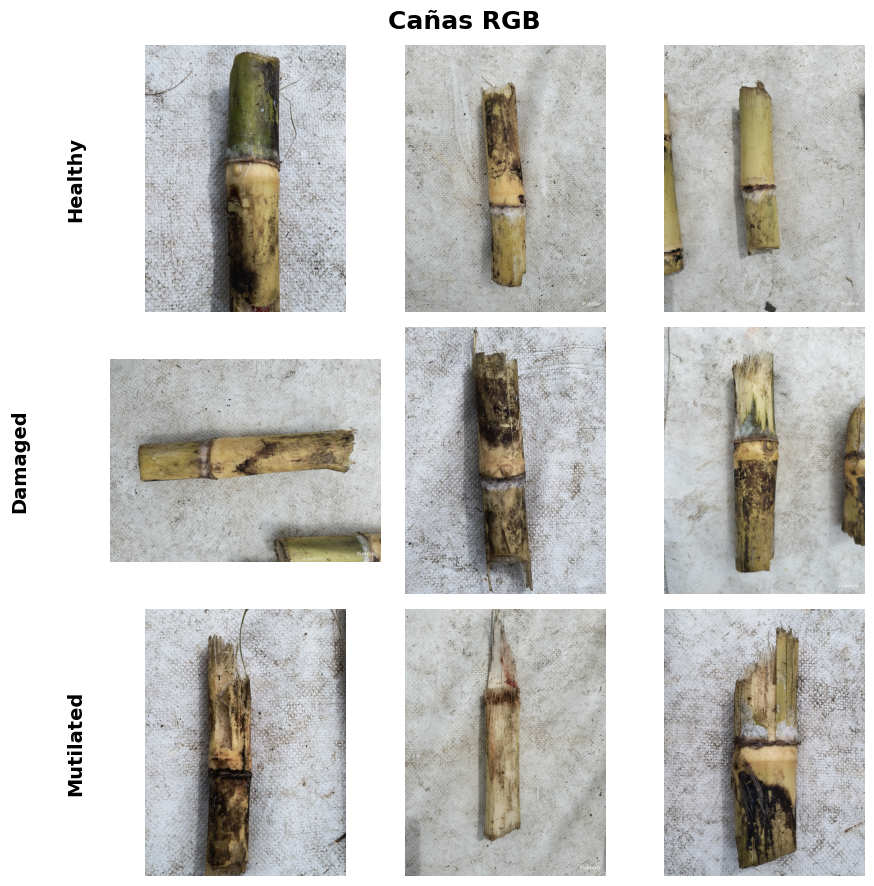

In [9]:
def show_images(title, healthy, damaged, mutilated, func=lambda a: a):
    fig, ax = plt.subplots(3, 3, figsize=(9, 9))
    for i in range(3):
        ax[0, i].imshow(func(healthy_sample[i]))
        ax[1, i].imshow(func(damaged_sample[i]))
        ax[2, i].imshow(func(mutilated_sample[i]))

        ax[0, i].axis('off')
        ax[1, i].axis('off')
        ax[2, i].axis('off')

        ax[i, 0].annotate(
        ["Healthy", "Damaged", "Mutilated"][i], 
        xy=(-0.3, 0.5), 
        xycoords="axes fraction", 
        fontsize=14, 
        ha="right", 
        va="center", 
        rotation=90, 
        fontweight="bold"
        )
    plt.suptitle(
        title,  
        fontsize=18,  
        fontweight='bold',
    )
    plt.tight_layout()
    plt.show()

show_images(
    title='Cañas RGB',
    healthy=healthy_sample,
    damaged=damaged_sample,
    mutilated=mutilated_sample
    )

**<h4>Espacios de color:</h4>**

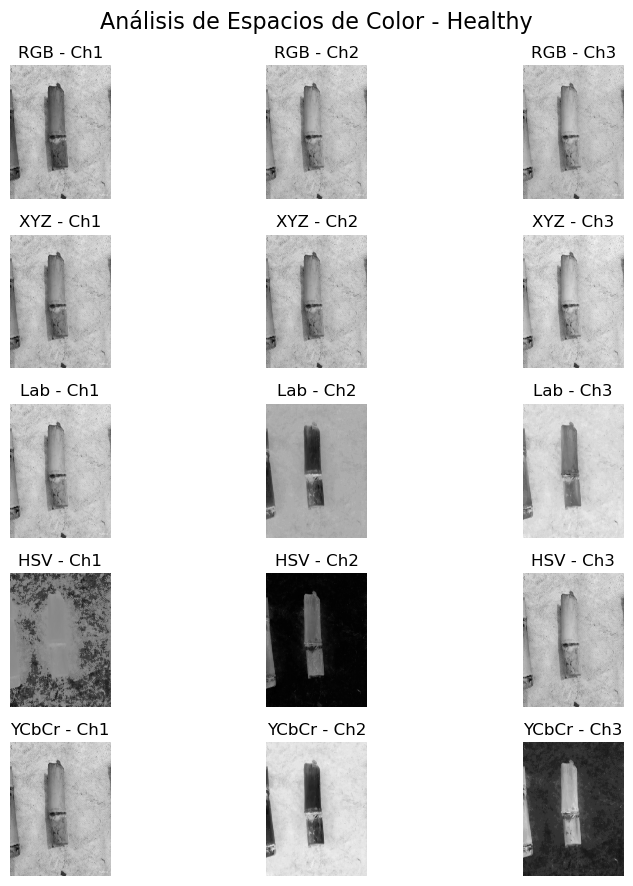

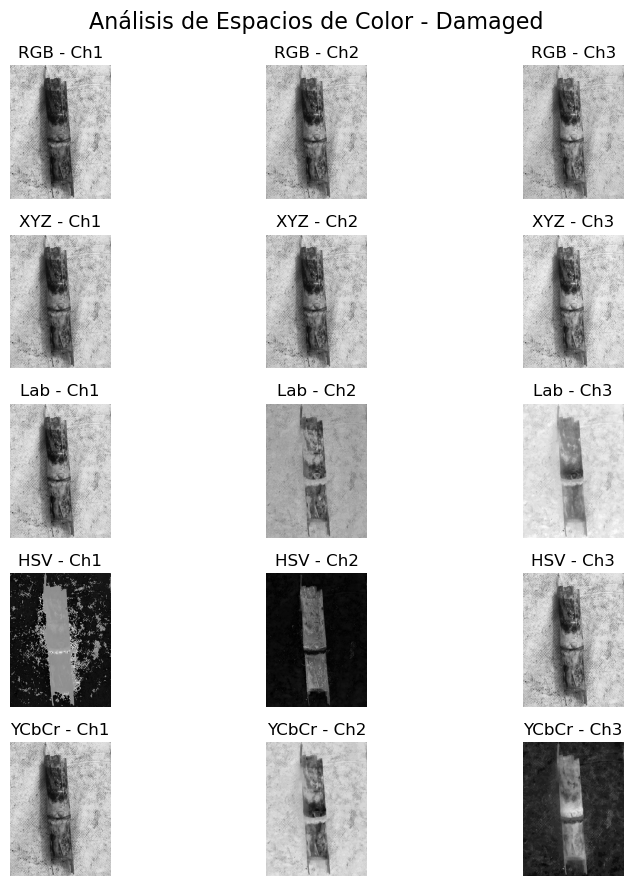

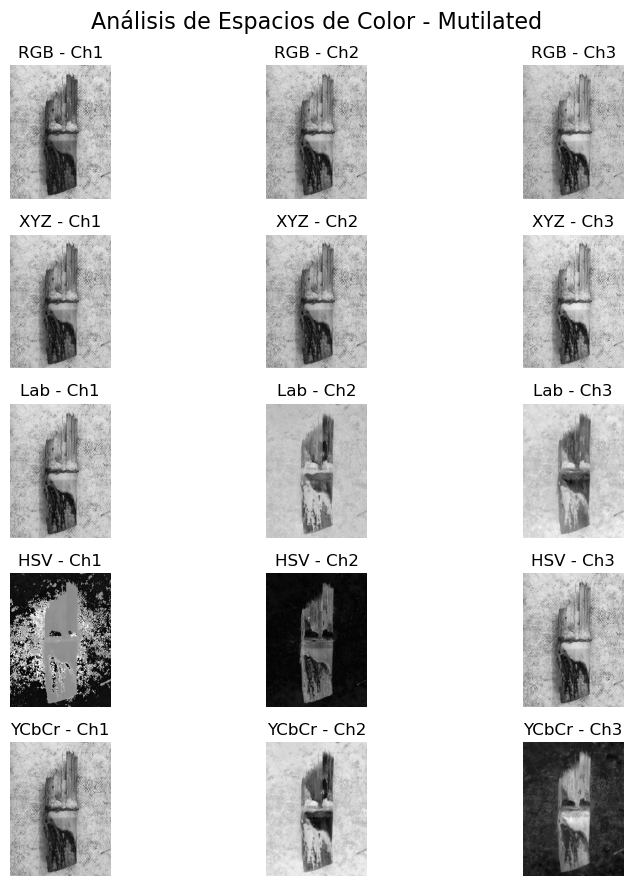

In [10]:
# Función para convertir imagen a diferentes espacios de color
def convert_color_spaces(image):
    return {
        "RGB": cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        "XYZ": cv2.cvtColor(image, cv2.COLOR_BGR2XYZ),
        "Lab": cv2.cvtColor(image, cv2.COLOR_BGR2Lab),
        "HSV": cv2.cvtColor(image, cv2.COLOR_BGR2HSV),
        "YCbCr": cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    }

# Función para mostrar los canales de un espacio de color
def plot_color_channels(image, category):
    color_spaces = ["RGB", "XYZ", "Lab", "HSV", "YCbCr"]
    fig, axes = plt.subplots(len(color_spaces), 3, figsize=(9, 9))
    
    converted = convert_color_spaces(image)
        
    for row, space in enumerate(color_spaces):
        channels = cv2.split(converted[space])
        for ch in range(3):
            ax = axes[row, ch]
            ax.imshow(channels[ch], cmap='gray')
            ax.axis("off")
            ax.set_title(f"{space} - Ch{ch+1}")
    
    plt.suptitle(f"Análisis de Espacios de Color - {category}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Mostrar gráficos para cada categoría
plot_color_channels(random.choice(healthy_sample), "Healthy")
plot_color_channels(random.choice(damaged_sample), "Damaged")
plot_color_channels(random.choice(mutilated_sample), "Mutilated")

**<h4>Histogramas de espacios de color:</h4>**

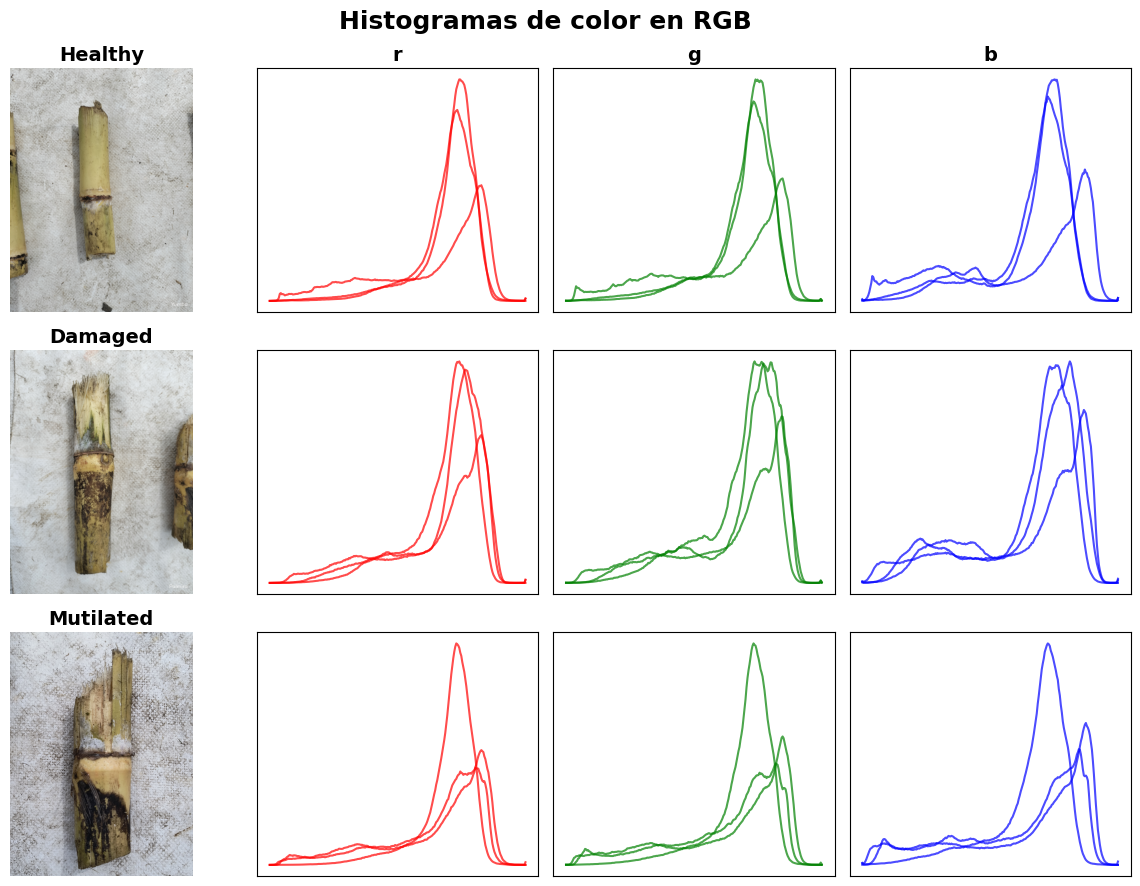

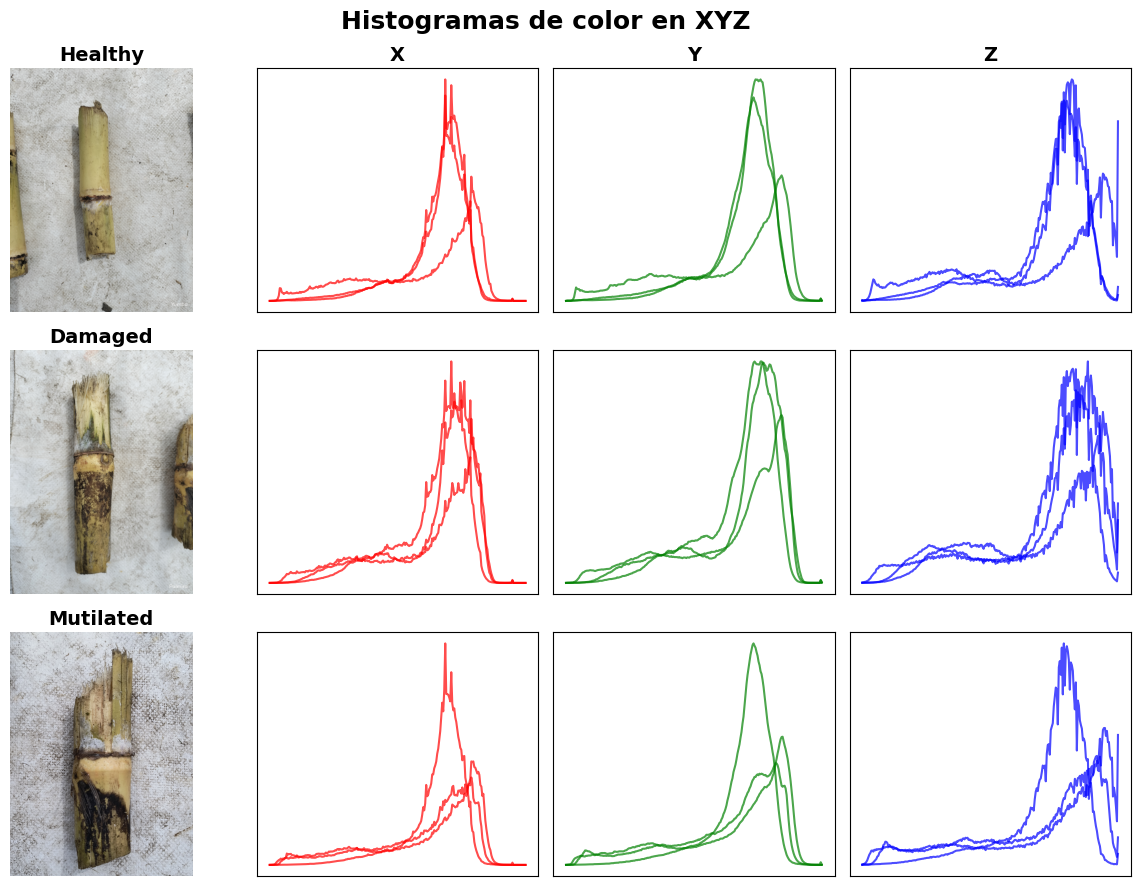

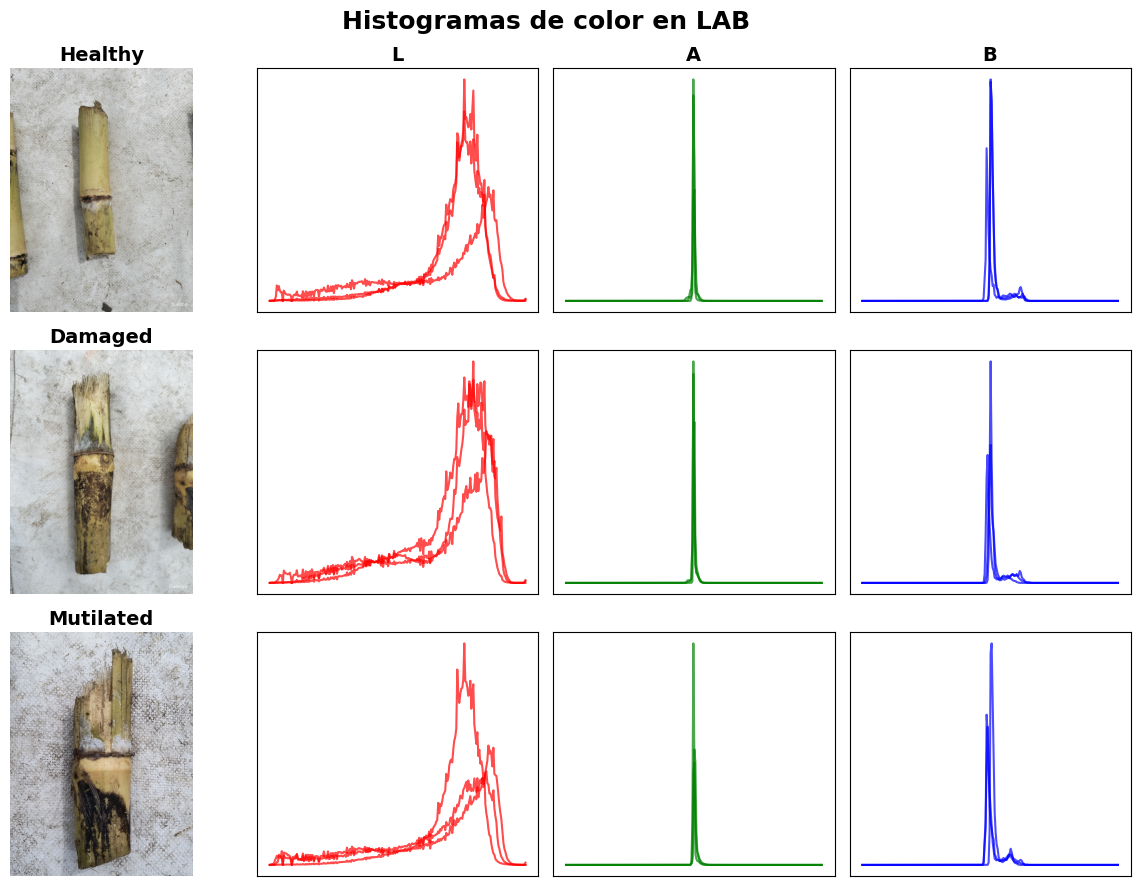

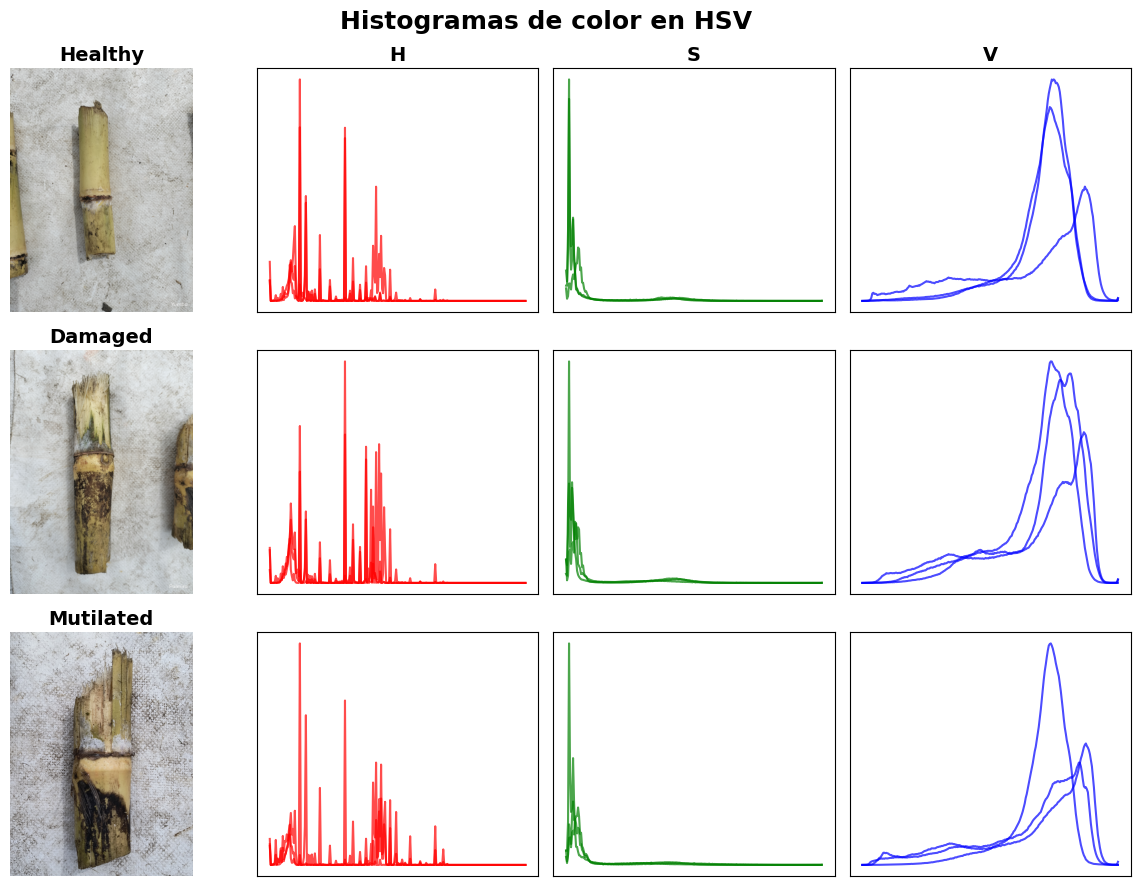

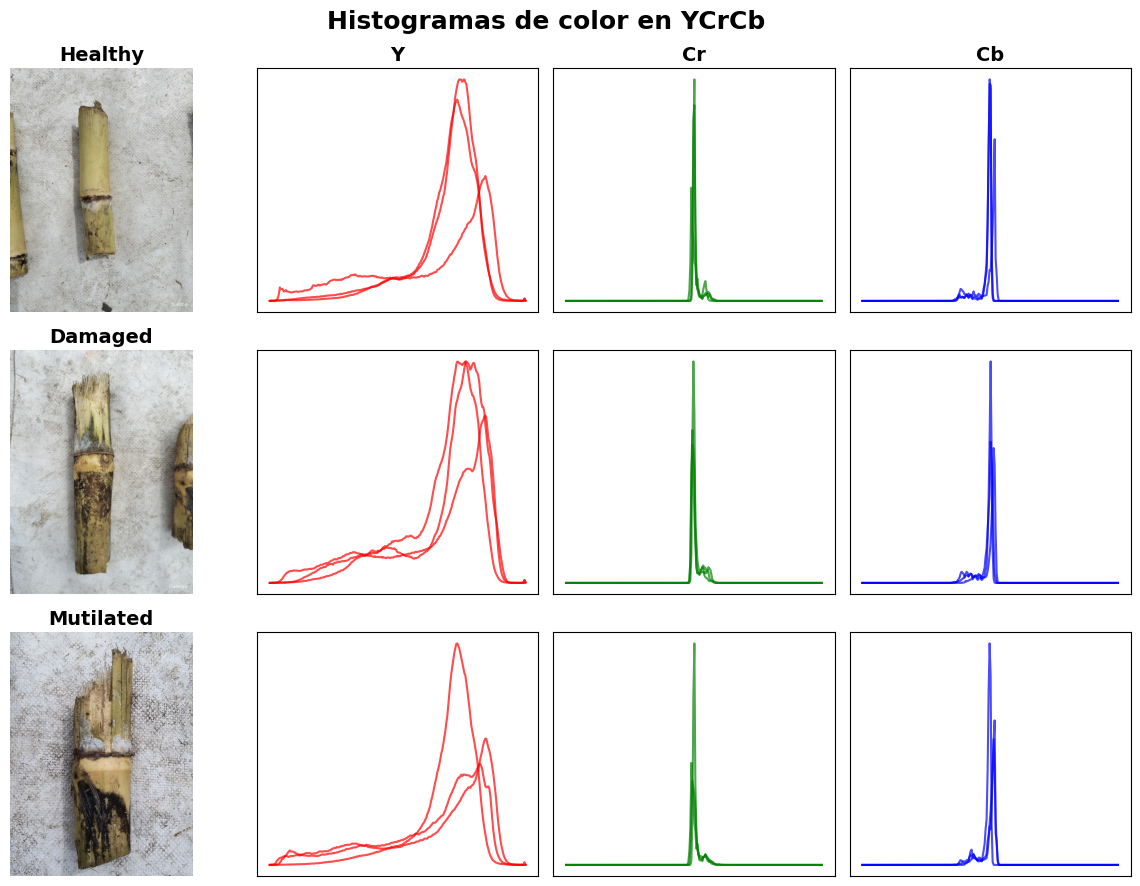

In [ ]:
def show_color_hists(healthy, damaged, mutilated, func=lambda a: a):
    color_spaces = {
        'RGB': ('r', 'g', 'b', lambda img: img),
        'XYZ': ('X', 'Y', 'Z', cv2.COLOR_RGB2XYZ),
        'LAB': ('L', 'A', 'B', cv2.COLOR_RGB2LAB),
        'HSV': ('H', 'S', 'V', cv2.COLOR_RGB2HSV),
        'YCrCb': ('Y', 'Cr', 'Cb', cv2.COLOR_RGB2YCrCb)
    }
    
    for space, (c1, c2, c3, conversion) in color_spaces.items():
        fig, ax = plt.subplots(3, 4, figsize=(12, 9))  # 3 filas (categorías) x 4 columnas (1 imagen + 3 canales)
        
        for i, category in enumerate([healthy, damaged, mutilated]):  # Iterar por categoría
            for j in range(3):  # Iterar por cada imagen de la categoría
                img = func(category[j])  # Obtener la imagen

                if space != 'RGB':
                    img = cv2.cvtColor(img, conversion)

                # Mostrar imagen original en la primera columna
                ax[i, 0].imshow(category[j])  # Mostrar la imagen correspondiente a la categoría
                ax[i, 0].axis("off")

                # Dibujar histogramas de cada canal
                for k, (channel_name, color) in enumerate(zip((c1, c2, c3), ('r', 'g', 'b'))):
                    hist, bins = np.histogram(img[:, :, k].ravel(), bins=256, range=(0, 256))
                    ax[i, k + 1].plot(hist, color=color, alpha=0.7)
                    ax[i, k + 1].set_xticks([])
                    ax[i, k + 1].set_yticks([])

            # Etiqueta en la primera columna de cada fila
            ax[i, 0].set_title(["Healthy", "Damaged", "Mutilated"][i], fontsize=14, fontweight="bold")

        # Agregar nombres de los canales en la parte superior de cada columna
        ax[0, 1].set_title(c1, fontsize=14, fontweight="bold")
        ax[0, 2].set_title(c2, fontsize=14, fontweight="bold")
        ax[0, 3].set_title(c3, fontsize=14, fontweight="bold")

        plt.suptitle(f"Histogramas de color en {space}", fontsize=18, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Llamar a la función con las imágenes
show_color_hists(healthy_sample, damaged_sample, mutilated_sample)


**<h5>Justificación de la Selección de los Mejores Canales de Color para el Análisis de Trozos de Caña</h5>**
Para determinar los canales de color más adecuados en la diferenciación de los trozos de caña en sus distintas condiciones (healthy, damaged y mutilated), se realizó un análisis de los histogramas en diversos espacios de color, incluyendo **RGB**, **XYZ**, **Lab**, **HSV** y **YCbCr**. A continuación, se describe el comportamiento observado en cada caso y se justifica la selección final de los canales más útiles.


**Análisis de la Distribución de los Histogramas en Diferentes Espacios de Color**

**RGB y XYZ:**
<ul>
    <li>En <b>RGB</b>, los tres canales muestran una mayor concentración de valores en el extremo derecho del histograma, lo que sugiere que predominan niveles altos de intensidad. Sin embargo, dentro de este espacio, el canal R parece ofrecer un mejor contraste en ciertos casos.</li>
    <li><b>XYZ</b> presenta un comportamiento muy similar a RGB, sin aportar información adicional relevante.</li>
    <li>En general, este espacio de color no facilita la segmentación, aunque algunos canales específicos podrían ser útiles.</li>

</ul>

**Lab:**
<ul>
    <li>En el canal <b>L</b>, la distribución sigue un patrón similar al de <b>RGB</b> y <b>XYZ</b>, con valores concentrados a la derecha, representando principalmente la luminosidad sin aportar mucho a la diferenciación.</li>
    <li>En el canal <b>a</b>, se observa un pico muy pronunciado en el centro del histograma, lo que indica una fuerte agrupación de valores en esa región, reduciendo el contraste entre las muestras.</li>
    <li>En el canal <b>b</b>, además del pico central muy pronunciado, hay un pequeño montículo cercano, lo que sugiere cierta variabilidad que podría ayudar a la diferenciación.</li>
</ul>

**HSV:**
<ul>
    <li>En el canal <b>H</b>, hay múltiples picos bien definidos, lo que indica diversidad en los tonos. Sin embargo, si están demasiado concentrados, la diferenciación entre tipos de trozos puede ser complicada.</li>
    <li>En el canal <b>S</b>, el histograma muestra un pico concentrado hacia la izquierda,  indicando baja saturación en la mayoría de los valores, aunque podría ser útil si existen diferencias entre las condiciones de los trozos.</li>
    <li>En el canal <b>V</b>, el mayor pico se encuentra a la derecha, lo que refleja una distribución de brillo similar a la observada en <b>RGB</b> y <b>Lab</b>.</li>
</ul>

**<b>YCbCr:</b>**  
<ul>
    <li>En el canal <b>Y</b>, la distribución es similar a la de <b>RGB</b>, lo que indica que representa principalmente la luminancia sin aportar demasiada diferenciación.</li>
    <li>En los canales <b>Cr</b> y <b>Cb</b>, los histogramas se asemejan a los de los canales <b>a</b> y <b>b</b> de <b>Lab</b>, con un pico muy pronunciado en el centro, pero con cierta variabilidad que podría ser útil para la segmentación.</li>
</ul>

**Selección de los Mejores Canales de Color**  

Basándonos en los contrastes observados y la capacidad de diferenciación entre los tipos de trozos de caña, los canales más adecuados para el análisis son:

<ul>
    <li><b>Canal R de RGB:</b> Aunque RGB en general no parecía la mejor opción, el canal R presenta mejor contraste que los otros dos y permite distinguir mejor los distintos estados de los trozos..</li>
    <li><b>Canal B de Lab:</b> Presenta una ligera variabilidad adicional que podría ayudar en la segmentación.</li>
    <li><b>Canal S de HSV:</b> Aunque la mayoría de valores están concentrados en la izquierda, podría resaltar diferencias en saturación.</li>
    <li><b>Canal Cb de YCbCr:</b> Su comportamiento es similar al canal B de Lab, mostrando cierta diferenciación entre muestras.</li>
</ul>

Estos canales destacan porque presentan más contraste y variabilidad en la distribución de valores, lo que facilitaría la segmentación y clasificación de los trozos de caña en sus distintas condiciones.

**<h5>Realce de contraste para seleccionar los mejores canales de color</h5>**

Para seleccionar el canal óptimo, se aplicaron técnicas de realce de contraste a las imágenes originales, para encontrar el canal que maximice la diferencia entre las regiones de caña y el fondo, así como entre tipos de caña.

Se probaron dos métodos distintos de realce de contraste sobre los canales más prometedores:

<ul>
    <li><b>Ecualización de histograma (HE):</b> Esta técnica redistribuye los niveles de intensidad de los píxeles de la imagen, asegurando que todos los valores tengan aproximadamente la misma cantidad de píxeles</li>
    <li><b>Normalización (Norm):</b> Este método escala los valores de los píxeles a un rango específico, ajustando la intensidad relativa de la imagen. Se implementa con:</li>
</ul>


 A continuación, se presentan los resultados obtenidos para cada canal:

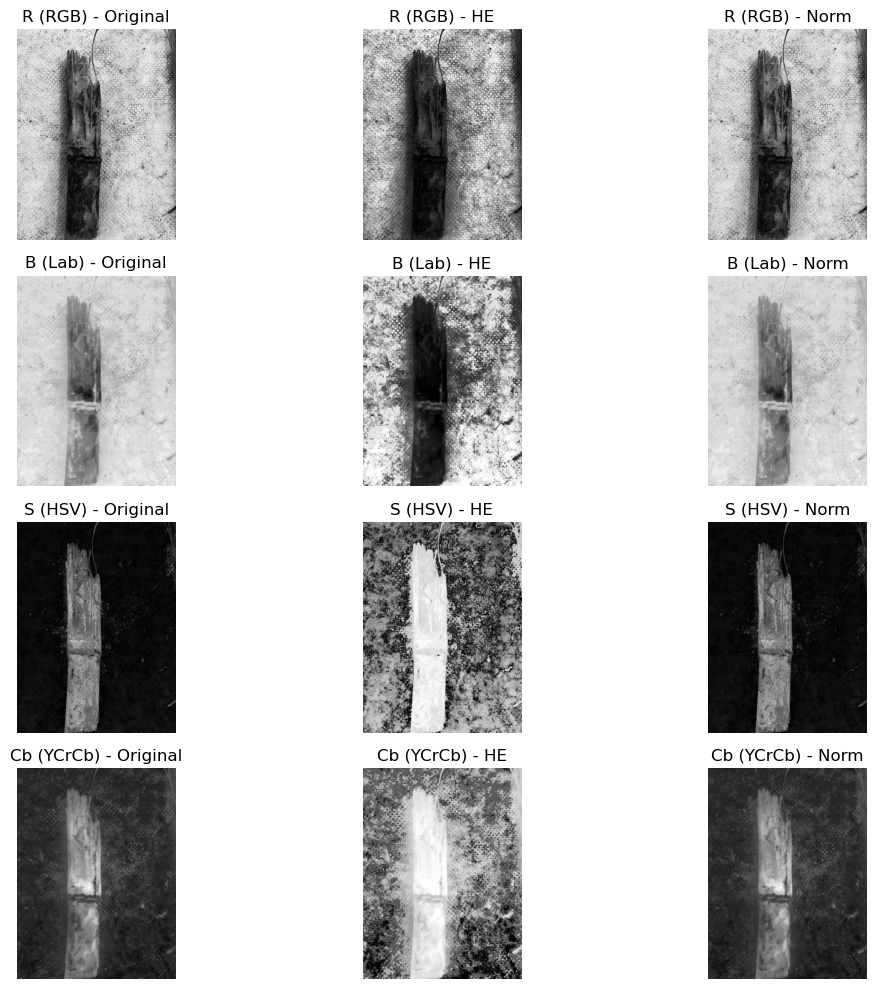

In [16]:
# Función para aplicar ecualización de histograma
def apply_hist_eq(image):
    return cv2.equalizeHist(image)

# Función para normalizar contraste
def normalize_image(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

# Usar una imagen de ejemplo de la lista mutilated_sample
img = random.choice(mutilated_sample)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

# Extraer canales seleccionados
r_channel = img_rgb[:, :, 0]
b_lab_channel = img_lab[:, :, 2]
s_hsv_channel = img_hsv[:, :, 1]
cb_ycrcb_channel = img_ycrcb[:, :, 2]

# Aplicar técnicas a cada canal
channels = {
    "R (RGB)": r_channel,
    "B (Lab)": b_lab_channel,
    "S (HSV)": s_hsv_channel,
    "Cb (YCrCb)": cb_ycrcb_channel
}

enhanced_images = {}

for name, channel in channels.items():
    he = apply_hist_eq(channel)
    norm = normalize_image(channel)
    
    enhanced_images[name] = {"Original": channel, "HE": he, "Norm": norm}

# Visualizar resultados
fig, axes = plt.subplots(len(enhanced_images), 3, figsize=(12, 10))

for i, (name, results) in enumerate(enhanced_images.items()):
    axes[i, 0].imshow(results["Original"], cmap='gray')
    axes[i, 0].set_title(f"{name} - Original")
    
    axes[i, 1].imshow(results["HE"], cmap='gray')
    axes[i, 1].set_title(f"{name} - HE")
    
    axes[i, 2].imshow(results["Norm"], cmap='gray')
    axes[i, 2].set_title(f"{name} - Norm")

for ax in axes.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()


**Análisis de los Resultados de las Técnicas de Realce de Contraste**

**Canal R de RGB:**

<ul>
<li><b>HE:</b> Mejora el contraste, pero genera texturas artificiales en el fondo.</li>
<li><b>Norm:</b> Un aumento de contraste más suave y uniforme.</li>
</ul>

**Canal B de Lab:**

<ul>
<li><b>HE:</b> Resalta mucho el objeto, pero el fondo se vuelve muy ruidoso.</li>
<li><b>Norm:</b> Apenas mejora el contraste, sigue siendo tenue.</li>
</ul>

**Canal S de HSV:**

<ul>
<li><b>HE:</b> Sobreexagera el objeto y genera un fondo con texturas no deseadas.</li>
<li><b>Norm:</b> Mantiene la diferencia, y realza un poco el contraste.</li>
</ul>

**Canal Cb de YCrCb:**

<ul>
<li><b>HE:</b> Aumenta el contraste, pero introduce mucho ruido.</li>
<li><b>Norm:</b> Mejora ligeramente el contraste, pero el fondo se mantiene con mucho ruido.</li>
</ul>

Después de aplicar estas técnicas a los canales seleccionados, se concluye que el mejor canal a usar es <b>S (HSV)</b>, ya que permite diferenciar mejor el objeto del fondo sin agregar ruido excesivo.

Además, dado que  <b>HE</b> generó buen contraste, pero introdujo ruido en los fondos,  mientras que <b>Norm</b> logró mejorar el contraste de forma suave, se decidió utilizar <b>NORM</b> en el preprocesamiento de imágenes para la segmentación.

**<h4>Detección de bordes</h4>**

Para la detección de bordes se utilizó el algoritmo de <b>Canny</b> con umbrales adaptativos basados en <b>Otsu</b>.

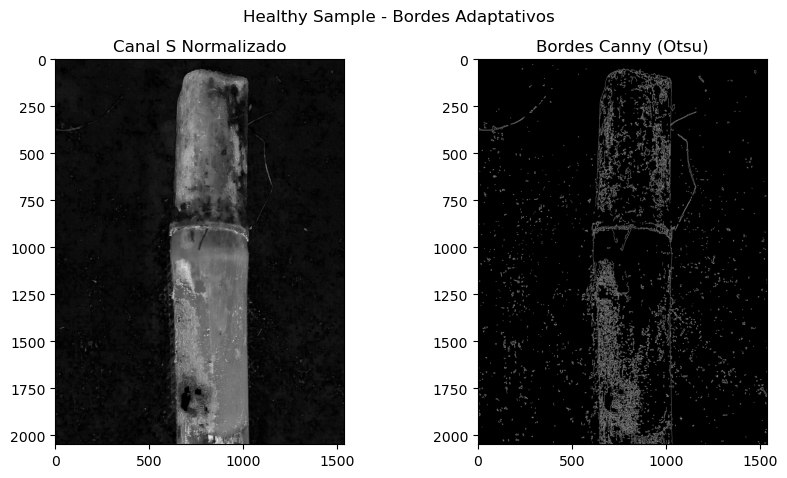

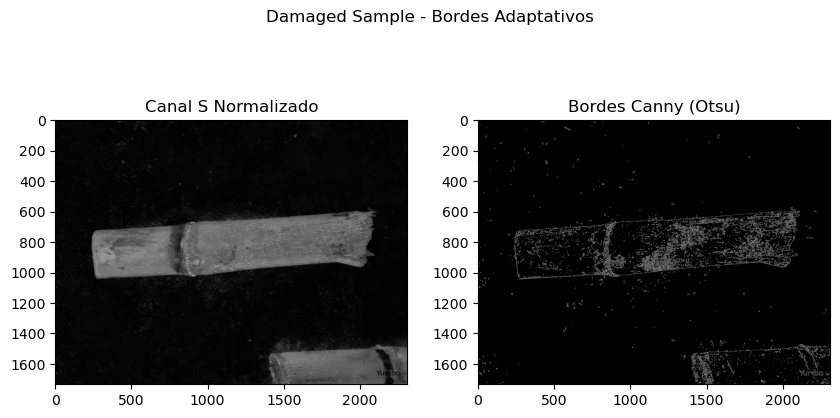

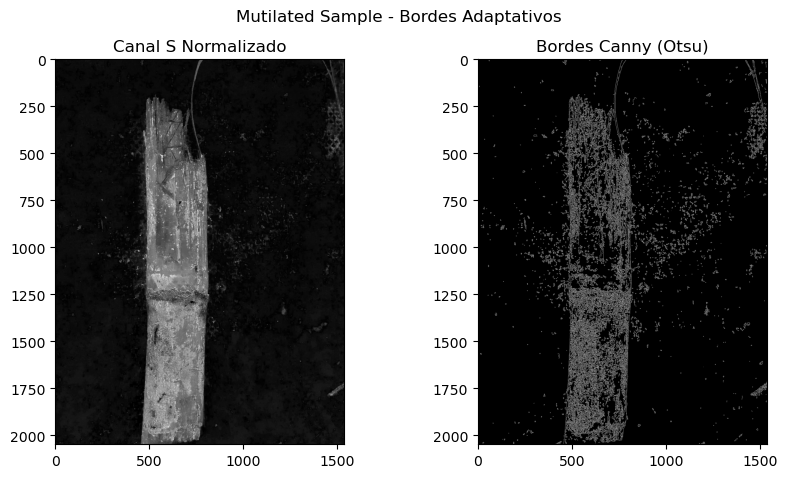

In [17]:
# Función para extraer el canal S (HSV)
def extraer_canal_s(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return img_hsv[:, :, 1]  # Extrae solo el canal S (Saturación)

# Procesar imágenes (Extraer canal S -> Normalizar)
healthy_s_norm = normalize_image(extraer_canal_s(healthy_sample[0]))
damaged_s_norm = normalize_image(extraer_canal_s(damaged_sample[0]))
mutilated_s_norm = normalize_image(extraer_canal_s(mutilated_sample[0]))

def detectar_bordes_adaptativo(img):
    # Calcular el umbral bajo con Otsu
    umbral1, _ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    umbral2 = umbral1 * 2  # Definir el umbral alto como el doble

    # Aplicar Canny con los umbrales ajustados
    bordes = cv2.Canny(img, umbral1, umbral2)
    return bordes

# Función para visualizar los bordes con umbrales automáticos
def mostrar_bordes_adaptativo(img, nombre):
    bordes = detectar_bordes_adaptativo(img)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Canal S Normalizado')

    plt.subplot(1, 2, 2)
    plt.imshow(bordes, cmap='gray')
    plt.title(f'Bordes Canny (Otsu)')

    plt.suptitle(nombre)
    plt.show()

# Aplicar detección de bordes adaptativa antes de segmentar
mostrar_bordes_adaptativo(healthy_s_norm, 'Healthy Sample - Bordes Adaptativos')
mostrar_bordes_adaptativo(damaged_s_norm, 'Damaged Sample - Bordes Adaptativos')
mostrar_bordes_adaptativo(mutilated_s_norm, 'Mutilated Sample - Bordes Adaptativos')

Tras analizar los resultados obtenidos, se observa que la estructura principal se detecta en gran medida, pero también aparecen bordes falsos debido a ruido y variaciones de iluminación.

**<h4>Segmentación</h4>**

El propósito de la segmentación es extraer automáticamente el trozo de caña de cada imagen para su posterior análisis. Esto nos ayuda a:
- Eliminar información irrelevante (fondo de la imagen).
- Resaltar diferencias entre trozos sanos, dañados y mutilados.
- Facilitar el procesamiento de características como textura, color y forma.

Para esto, utilizamos dos métodos principales:
1. **Segmentación de Otsu**: Un umbral automático basado en histogramas.
2. **Segmentación con K-Means**: Un algoritmo de agrupamiento que asigna cada píxel a uno de dos grupos (caña o fondo).

**Problema detectado con K-Means**

Durante la implementación, notamos que K-Means no siempre asignaba el mismo color a la caña y al fondo. En algunos casos, el trozo de caña aparecía en negro (0) en lugar de blanco (255), mientras que el fondo se mostraba en blanco. Esto sucedía debido a que el algoritmo K-Means asigna etiquetas arbitrarias a los clusters en cada ejecución. Es decir, en una imagen puede asignar: **Cluster 0 → Fondo y Cluster 1 → Caña**, pero en otra imagen puede invertirlo: **Cluster 0 → Caña y Cluster 1 → Fondo**, lo que genera inconsistencias.

**Solución Implementada**

Para asegurarnos de que la caña siempre aparezca en blanco (255) y el fondo en negro (0), modificamos la función de segmentación de K-Means para revisar la intensidad media de cada cluster y corregir la asignación de etiquetas, de manera que el cluster con la mayor intensidad siempre sea blanco. De esta forma garantizamos que el proceso de segmentación sea consistente y los resultados sean confiables.


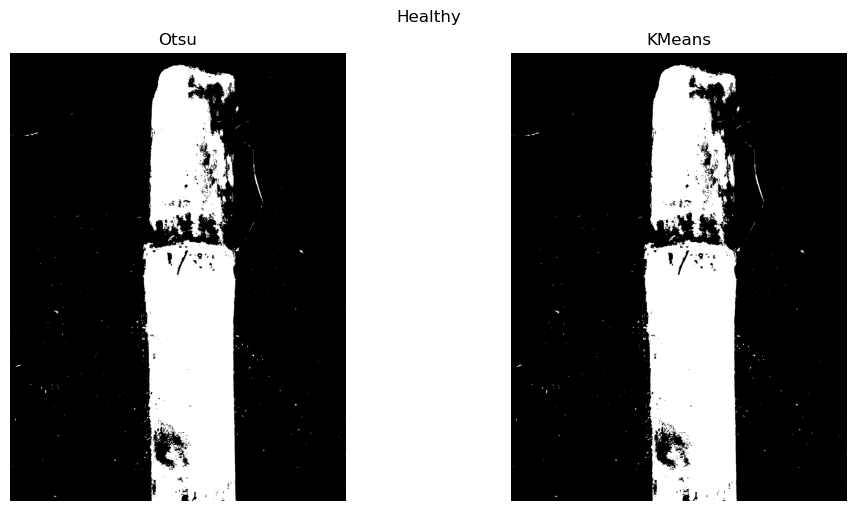

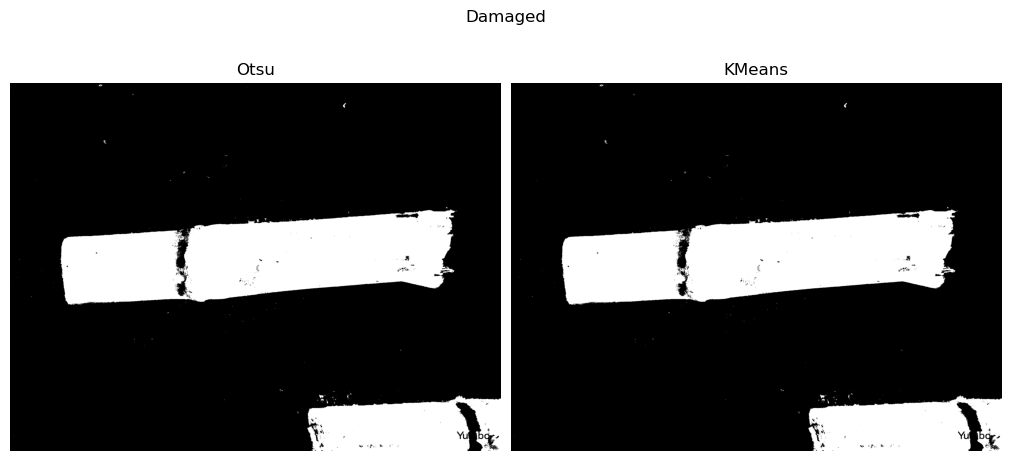

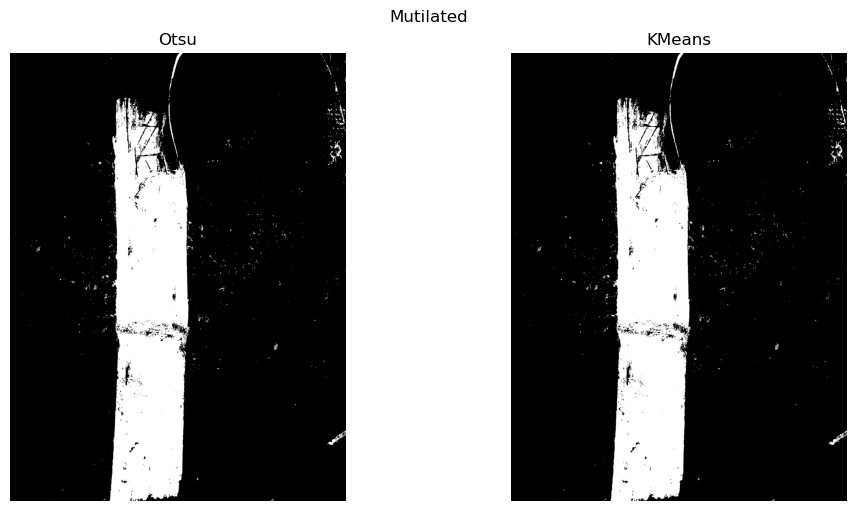

In [19]:
# Función para preparar directorio de salida
def preparar_directorio_salida():
    carpeta_salida = "segmentaciones"
    
    if os.path.exists(carpeta_salida):
        shutil.rmtree(carpeta_salida)
    
    os.makedirs(carpeta_salida)

# Segmentación Otsu mejorada
def segmentar_otsu(canal):
    _, binarizada = cv2.threshold(canal, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binarizada

# Segmentación K-Means optimizada
def segmentar_kmeans(img, clusters=2):
    img_reshaped = img.reshape((-1, 1)).astype(np.float32)
    kmeans = KMeans(n_clusters=clusters, random_state=0, n_init=10).fit(img_reshaped)
    segmented = kmeans.labels_.reshape(img.shape)
    
     # Asegurar que el cluster con el valor más alto se asigne a 255 (blanco)
    if np.mean(img[segmented == 0]) > np.mean(img[segmented == 1]):
        segmented = np.where(segmented == 0, 255, 0)
    else:
        segmented = np.where(segmented == 1, 255, 0)
    
    return segmented.astype(np.uint8)

# Función principal de procesamiento
def procesar_y_guardar_segmentaciones(img_normalizada, nombre):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
    
    # Generar segmentaciones
    otsu = segmentar_otsu(img_normalizada)
    kmeans = segmentar_kmeans(img_normalizada)
    
    # Configurar visualización
    segmentaciones = [otsu, kmeans]
    nombres = ["Otsu", "KMeans"]
    
    for ax, img, nombre_seg in zip(axes, segmentaciones, nombres):
        ax.imshow(img, cmap="gray")
        ax.set_title(nombre_seg)
        ax.axis('off')
        
        # Guardar archivo
        ruta_guardado = f"segmentaciones/{nombre}_{nombre_seg}.png"
        cv2.imwrite(ruta_guardado, img)
    
    plt.suptitle(nombre)
    plt.show()

# Ejecución del pipeline
preparar_directorio_salida()

# Procesar muestras (asumiendo que existen las variables de entrada)
procesar_y_guardar_segmentaciones(healthy_s_norm, 'Healthy')
procesar_y_guardar_segmentaciones(damaged_s_norm, 'Damaged')
procesar_y_guardar_segmentaciones(mutilated_s_norm, 'Mutilated')

**<h4>Limpieza de Segmentaciones</h4>**

Una vez que hemos segmentado los trozos de caña utilizando métodos como Otsu y K-Means, es común encontrar que las segmentaciones contienen ruido, bordes irregulares o pequeños artefactos que pueden afectar el análisis posterior. Para resolver esto, se implementa un proceso de limpieza sobre la segmentación binaria.

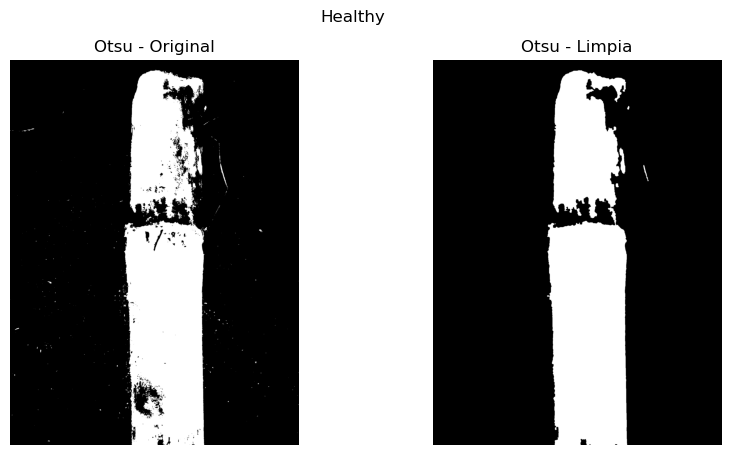

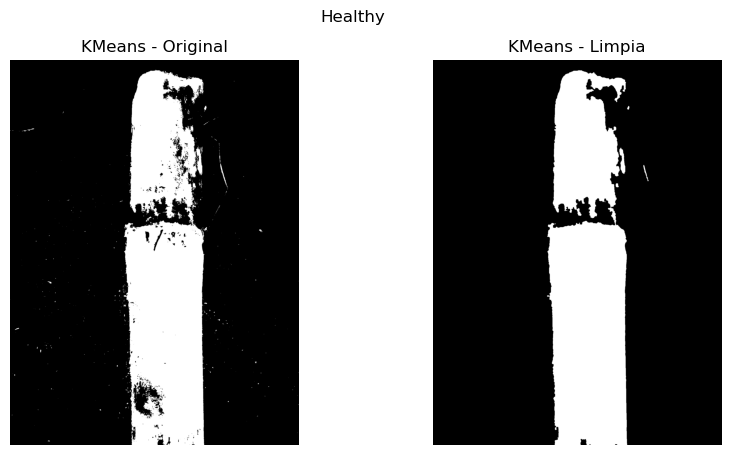

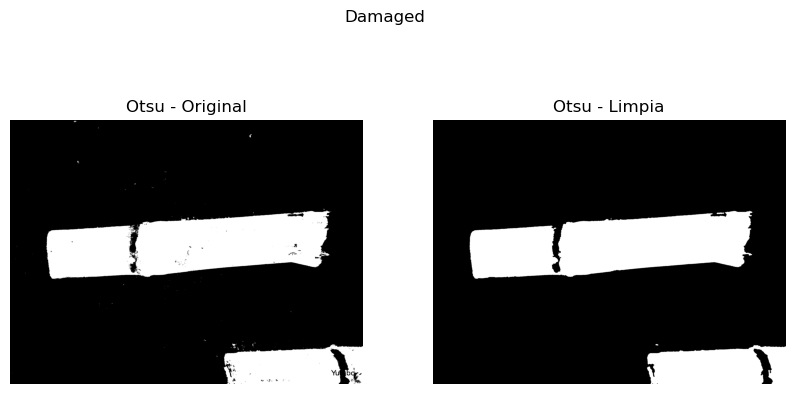

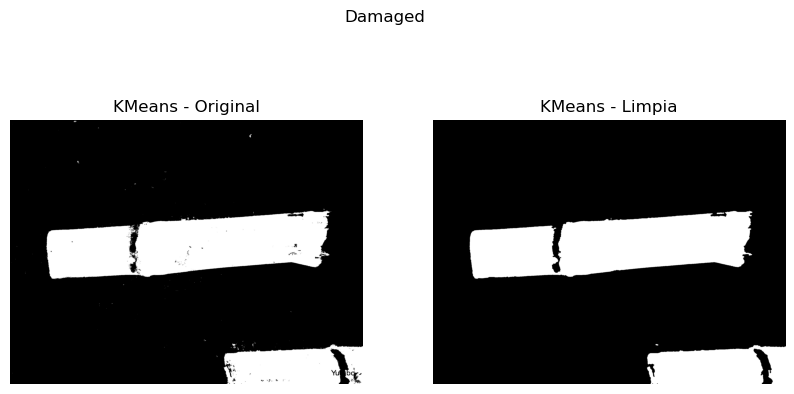

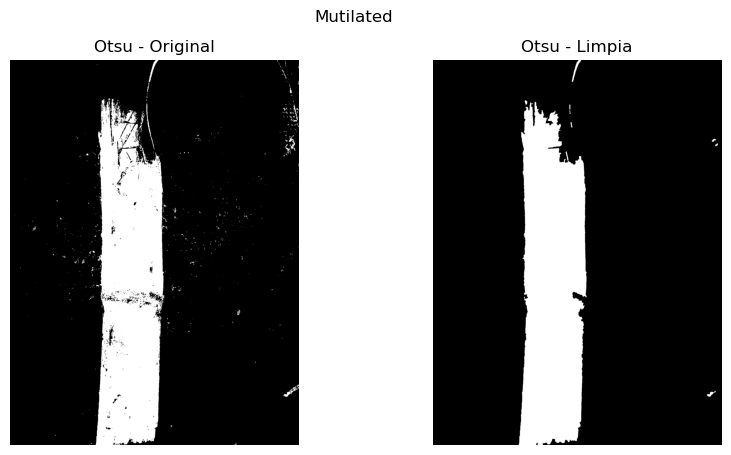

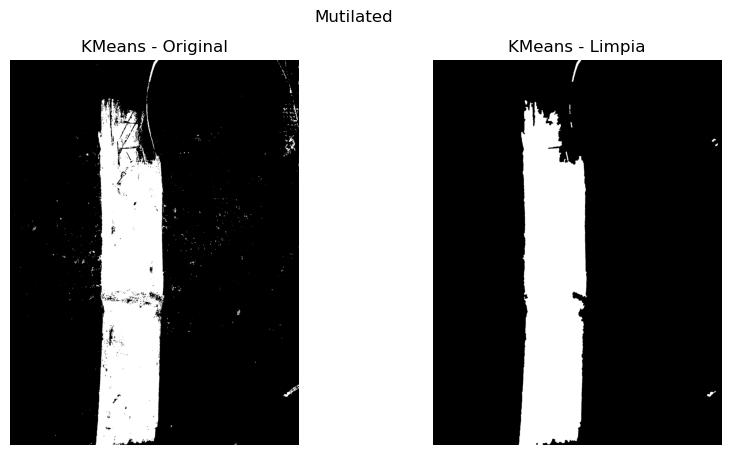

In [20]:
def limpiar_segmentacion(mask):
    """
    Aplica técnicas de limpieza sobre la segmentación binaria.
    """
    kernel = np.ones((3,3), np.uint8)

    # Asegurar que la máscara sea de tipo uint8
    mask = mask.astype(np.uint8)

    # 1. Eliminación de ruido con apertura (erosión + dilatación)
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # 2. Suavizado de bordes con filtro mediana
    mask_clean = cv2.medianBlur(mask_clean, 5)

    # 3. Cierre morfológico para rellenar huecos
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 4. Eliminar objetos pequeños (basado en área)
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area = 100  # Área mínima permitida para un contorno
    mask_filtered = np.zeros_like(mask_clean)

    for cnt in contours:
        if cv2.contourArea(cnt) > min_area:
            cv2.drawContours(mask_filtered, [cnt], -1, 255, thickness=cv2.FILLED)

    return mask_filtered

# Función para preparar la carpeta de salida
def preparar_directorio_salida_limpia():
    carpeta_salida = "segmentaciones_limpias"
    
    if os.path.exists(carpeta_salida):
        shutil.rmtree(carpeta_salida)
    
    os.makedirs(carpeta_salida)

# Lista de imágenes a procesar
nombres = ["Healthy", "Damaged", "Mutilated"]
metodos = ["Otsu", "KMeans"]

# Preparar carpeta de salida
preparar_directorio_salida_limpia()

# Procesar segmentaciones ya guardadas
for nombre in nombres:
    for metodo in metodos:
        # Cargar imagen segmentada
        ruta_entrada = f"segmentaciones/{nombre}_{metodo}.png"
        img_segmentada = cv2.imread(ruta_entrada, cv2.IMREAD_GRAYSCALE)
        
        if img_segmentada is not None:
            # Aplicar limpieza
            img_limpia = limpiar_segmentacion(img_segmentada)

            # Guardar imagen limpia
            ruta_salida = f"segmentaciones_limpias/{nombre}_{metodo}_Limpia.png"
            cv2.imwrite(ruta_salida, img_limpia)

            # Mostrar resultados
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(img_segmentada, cmap="gray")
            axes[0].set_title(f"{metodo} - Original")
            axes[0].axis("off")

            axes[1].imshow(img_limpia, cmap="gray")
            axes[1].set_title(f"{metodo} - Limpia")
            axes[1].axis("off")

            plt.suptitle(nombre)
            plt.show()
        else:
            print(f"Advertencia: No se pudo cargar {ruta_entrada}")

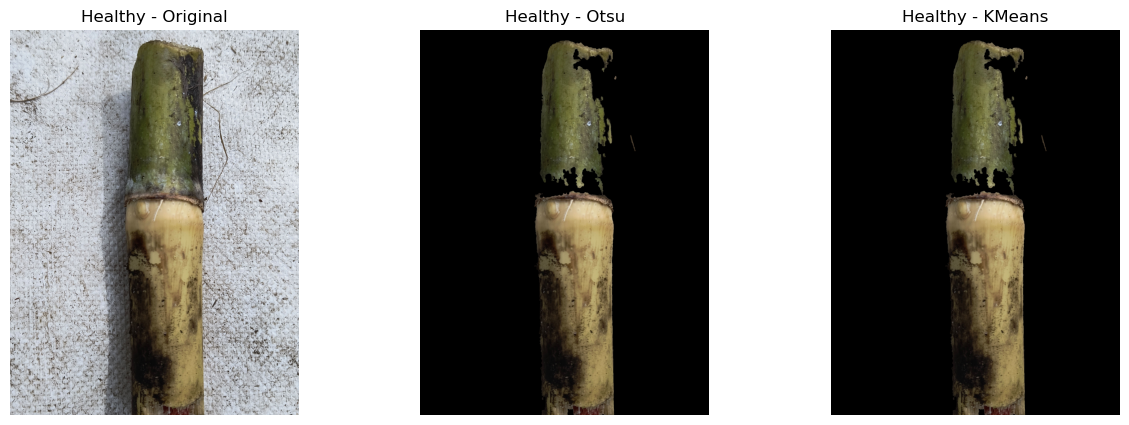

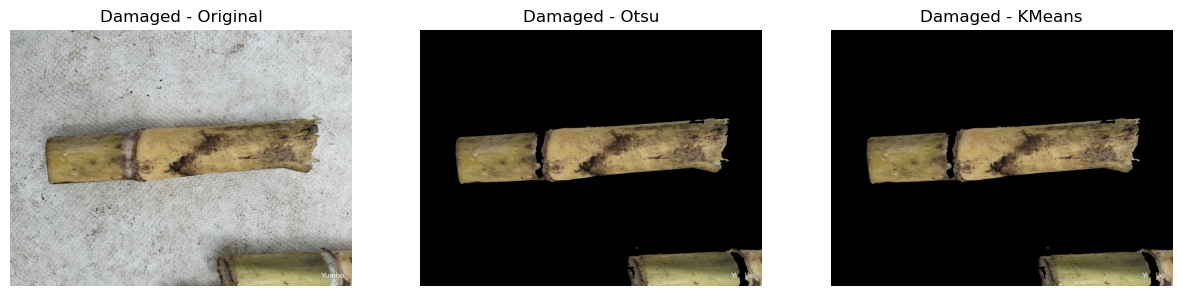

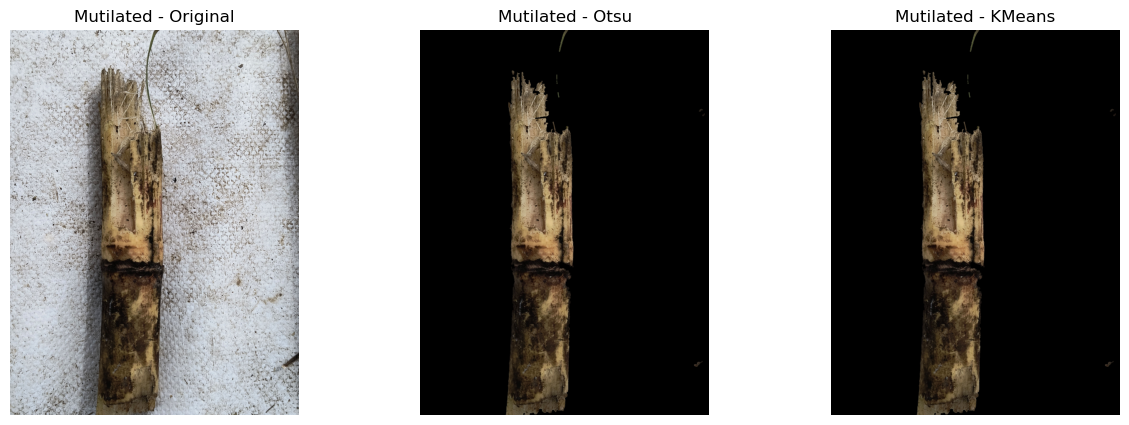

In [ ]:
def aplicar_mascara(img_original, mask):
    mask_binaria = (mask > 0).astype(np.uint8)  # Convertir a binario (0 o 1)
    img_segmentada = cv2.bitwise_and(img_original, img_original, mask=mask_binaria)
    return img_segmentada

def procesar_y_mostrar_segmentaciones(nombre_img, img_original):
    segmentaciones_limpias_dir = "segmentaciones_limpias"
    metodos = ["Otsu", "KMeans"]
    
    fig, axes = plt.subplots(1, len(metodos) + 1, figsize=(15, 5))
    
    # Mostrar imagen original
    axes[0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"{nombre_img} - Original")
    axes[0].axis('off')
    
    for i, metodo in enumerate(metodos):
        ruta_segmentacion = f"{segmentaciones_limpias_dir}/{nombre_img}_{metodo}_Limpia.png"
        if not os.path.exists(ruta_segmentacion):
            print(f"Advertencia: No se encontró {ruta_segmentacion}, saltando...")
            continue

        # Cargar la máscara limpia
        mask_limpia = cv2.imread(ruta_segmentacion, cv2.IMREAD_GRAYSCALE)

        # Aplicar la máscara sobre la imagen original con fondo negro
        img_segmentada = aplicar_mascara(img_original, mask_limpia)

        # Mostrar resultado en la misma fila
        axes[i + 1].imshow(cv2.cvtColor(img_segmentada, cv2.COLOR_BGR2RGB))
        axes[i + 1].set_title(f"{nombre_img} - {metodo}")
        axes[i + 1].axis('off')
    
    plt.show()

# Cargar imágenes de muestra
healthy_rgb = cv2.cvtColor(healthy_sample[0], cv2.COLOR_BGR2RGB)
damaged_rgb = cv2.cvtColor(damaged_sample[0], cv2.COLOR_BGR2RGB)
mutilated_rgb = cv2.cvtColor(mutilated_sample[0], cv2.COLOR_BGR2RGB)

# Ejecutar procesamiento y mostrar resultados
procesar_y_mostrar_segmentaciones("Healthy", healthy_rgb)
procesar_y_mostrar_segmentaciones("Damaged", damaged_rgb)
procesar_y_mostrar_segmentaciones("Mutilated", mutilated_rgb)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4ca19b05-25ab-4ed4-9f1b-6edc1d60a427' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>